#**Training d-DNN and e-DNNs using CPR coincidences over the coast**

In [ ]:
#importing the packages

from scipy.io import loadmat
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import h5py
import tensorflow as tf
import os
import scipy.io

## **1. Data**

### **1.1 Data Loading and Organizing** 

In [ ]:
f = h5py.File('Data/Dictionaries/Dic_DPR_ocean.mat','r')
list(f.keys())

['X_ocean_trn_detection',
 'X_ocean_tst_detection',
 'X_rain_ocean_trn_retrieval',
 'X_rain_ocean_tst_retrieval',
 'X_snow_ocean_trn_retrieval',
 'X_snow_ocean_tst_retrieval',
 'y_ocean_trn_detection',
 'y_ocean_tst_detection',
 'y_rain_ocean_trn_retrieval',
 'y_rain_ocean_tst_retrieval',
 'y_snow_ocean_trn_retrieval',
 'y_snow_ocean_tst_retrieval']

In [ ]:
X1_trn_detection = np.transpose(f['X_ocean_trn_detection'])
y_trn_detection = np.transpose(f['y_ocean_trn_detection'])
X1_tst_detection = np.transpose(f['X_ocean_tst_detection'])
y_tst_detection = np.transpose(f['y_ocean_tst_detection'])

X1_rain_trn_retrieval = np.transpose(f['X_rain_ocean_trn_retrieval'])
y_rain_trn_retrieval = np.transpose(f['y_rain_ocean_trn_retrieval'])
X1_rain_tst_retrieval = np.transpose(f['X_rain_ocean_tst_retrieval'])
y_rain_tst_retrieval = np.transpose(f['y_rain_ocean_tst_retrieval'])

X1_snow_trn_retrieval = np.transpose(f['X_snow_ocean_trn_retrieval'])
y_snow_trn_retrieval = np.transpose(f['y_snow_ocean_trn_retrieval'])
X1_snow_tst_retrieval = np.transpose(f['X_snow_ocean_tst_retrieval'])
y_snow_tst_retrieval = np.transpose(f['y_snow_ocean_tst_retrieval'])

In [ ]:
X1_trn_detection.astype('float64')
X1_tst_detection.astype('float64')
y_trn_detection.astype('int64')
y_tst_detection.astype('int64')

X1_rain_trn_retrieval.astype('float64')
X1_rain_tst_retrieval.astype('float64')
y_rain_trn_retrieval.astype('float64')
y_rain_tst_retrieval.astype('float64')

X1_snow_trn_retrieval.astype('float64')
X1_snow_tst_retrieval.astype('float64')
y_snow_trn_retrieval.astype('float64')
y_snow_tst_retrieval.astype('float64');

### **1.2 Data Normalizing**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets.

In [ ]:
mean_detection = X1_trn_detection.mean(axis=0)
X2_trn_detection = X1_trn_detection-mean_detection
std_detection = X1_trn_detection.std(axis=0)
X_trn_detection = X2_trn_detection/std_detection
X2_tst_detection = X1_tst_detection-mean_detection
X_tst_detection = X2_tst_detection/std_detection

mean_rain_retrieval = X1_rain_trn_retrieval.mean(axis=0)
X2_rain_trn_retrieval = X1_rain_trn_retrieval-mean_rain_retrieval
std_rain_retrieval = X1_rain_trn_retrieval.std(axis=0)
X_rain_trn_retrieval = X2_rain_trn_retrieval/std_rain_retrieval
X2_rain_tst_retrieval = X1_rain_tst_retrieval-mean_rain_retrieval
X_rain_tst_retrieval = X2_rain_tst_retrieval/std_rain_retrieval

mean_snow_retrieval = X1_snow_trn_retrieval.mean(axis=0)
X2_snow_trn_retrieval = X1_snow_trn_retrieval-mean_snow_retrieval
std_snow_retrieval = X1_snow_trn_retrieval.std(axis=0)
X_snow_trn_retrieval = X2_snow_trn_retrieval/std_snow_retrieval
X2_snow_tst_retrieval = X1_snow_tst_retrieval-mean_snow_retrieval
X_snow_tst_retrieval = X2_snow_tst_retrieval/std_snow_retrieval

In [ ]:
# Removing the outliers
x_snow_lb = 0.0 #np.percentile(y_snow_trn_retrieval,0.05)
x_snow_ub = np.percentile(y_snow_trn_retrieval,99.95)

x_rain_lb = 0.01 #np.percentile(y_rain_trn_retrieval,0.05)
x_rain_ub = np.percentile(y_rain_trn_retrieval,99.95)

mask_trn_snow = (y_snow_trn_retrieval>=x_snow_lb) & (y_snow_trn_retrieval<=x_snow_ub)
m_trn_snow=mask_trn_snow[:,0]
mask_tst_snow = (y_snow_tst_retrieval>=x_snow_lb) & (y_snow_tst_retrieval<=x_snow_ub)
m_tst_snow=mask_tst_snow[:,0]

mask_trn_rain = (y_rain_trn_retrieval>=x_rain_lb) & (y_rain_trn_retrieval<=x_rain_ub)
m_trn_rain=mask_trn_rain[:,0]
mask_tst_rain = (y_rain_tst_retrieval>=x_rain_lb) & (y_rain_tst_retrieval<=x_rain_ub)
m_tst_rain=mask_tst_rain[:,0]

Xf_snow_trn_detection = np.delete(X_trn_detection, ~m_trn_snow, axis=0)
yf_snow_trn_detection = np.delete(y_trn_detection, ~m_trn_snow, axis=0)
Xf_snow_tst_detection = np.delete(X_tst_detection, ~m_tst_snow, axis=0)
yf_snow_tst_detection = np.delete(y_tst_detection, ~m_tst_snow, axis=0)

Xf_snow_trn_retrieval = np.delete(X_snow_trn_retrieval, ~m_trn_snow, axis=0)
yf_snow_trn_retrieval = np.delete(y_snow_trn_retrieval, ~m_trn_snow, axis=0)
Xf_snow_tst_retrieval = np.delete(X_snow_tst_retrieval, ~m_tst_snow, axis=0)
yf_snow_tst_retrieval = np.delete(y_snow_tst_retrieval, ~m_tst_snow, axis=0)

Xf_rain_trn_detection = np.delete(X_trn_detection, ~m_trn_rain, axis=0)
yf_rain_trn_detection = np.delete(y_trn_detection, ~m_trn_rain, axis=0)
Xf_rain_tst_detection = np.delete(X_tst_detection, ~m_tst_rain, axis=0)
yf_rain_tst_detection = np.delete(y_tst_detection, ~m_tst_rain, axis=0)

Xf_rain_trn_retrieval = np.delete(X_rain_trn_retrieval, ~m_trn_rain, axis=0)
yf_rain_trn_retrieval = np.delete(y_rain_trn_retrieval, ~m_trn_rain, axis=0)
Xf_rain_tst_retrieval = np.delete(X_rain_tst_retrieval, ~m_tst_rain, axis=0)
yf_rain_tst_retrieval = np.delete(y_rain_tst_retrieval, ~m_tst_rain, axis=0)

x_snow_lb, x_snow_ub, x_rain_lb, x_rain_ub

(0.0, 6.394437945605132, 0.01, 61.75750654031647)

#### Checking the balance between labels in train and test set

In [ ]:
print('***Training Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==1:
        n_snow+=1
        t_train[i]=2
    if label==2:
        n_rain+=1  
        t_train[i]=1
    if label==3:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==1:
        n_snow+=1
        t_test[i]=2
    if label==2:
        n_rain+=1  
        t_test[i]=1
    if label==3:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 174722
Num. of rainfall: 175156
Num. of clear-sky: 350125

***Testing Dataset:

Num. of snowfall: 75143
Num. of rainfall: 75214
Num. of clear-sky: 149646


In [ ]:
print('\n***Truth Checking - Rain:\n')

n_snow=1
n_rain=1
n_clear=1  
tf_test_rain = np.zeros([yf_rain_tst_detection.shape[0],1])

for i in range(len(Xf_rain_tst_detection)):
    label = yf_rain_tst_detection[i]
    if label==1:
        n_snow+=1
        tf_test_rain[i]=2
    if label==2:
        n_rain+=1  
        tf_test_rain[i]=1
    if label==3:
        n_clear+=1
        tf_test_rain[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Truth Checking - Snow:\n')

n_snow=1
n_rain=1
n_clear=1  
tf_test_snow = np.zeros([yf_snow_tst_detection.shape[0],1])

for i in range(len(Xf_snow_tst_detection)):
    label = yf_snow_tst_detection[i]
    if label==1:
        n_snow+=1
        tf_test_snow[i]=2
    if label==2:
        n_rain+=1  
        tf_test_snow[i]=1
    if label==3:
        n_clear+=1
        tf_test_snow[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)


***Truth Checking - Rain:

Num. of snowfall: 1
Num. of rainfall: 75048
Num. of clear-sky: 1

***Truth Checking - Snow:

Num. of snowfall: 74992
Num. of rainfall: 75214
Num. of clear-sky: 149646


In [ ]:
#Chnaging the labels to catagorical
t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# **2. Training the networks**

### **2.1 - Detection Network (d-DNN)** 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential

In [ ]:
# Defining the architecture of the d-DNN network which has 6 layers and 30 hidden units in each layer.

# Parameters
hidden_units = 30
dropout = 0

# Detection Module
model_detection = Sequential()

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(3))
model_detection.add(Activation('softmax'))

In [ ]:
# Compiling the model by defining the loss function and learning rate.

model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])

In [ ]:
# Defining the callback list for early stoping and saving the model.

from tensorflow import keras
callbacks_list = [
#     keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]

In [ ]:
# Training the network (batch_size= 40, epoch = 300)

print('\nFitting DNN (Detection Module):\n')
batch_size1 = 1800
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=400,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Detection Module):

Epoch 1/400
312/312 [==============================] - 1s 4ms/step - loss: 0.8718 - recall: 0.2670 - val_loss: 0.6200 - val_recall: 0.6526
Epoch 2/400
312/312 [==============================] - 1s 3ms/step - loss: 0.4575 - recall: 0.7916 - val_loss: 0.3852 - val_recall: 0.8313
Epoch 3/400
312/312 [==============================] - 1s 3ms/step - loss: 0.3576 - recall: 0.8464 - val_loss: 0.3399 - val_recall: 0.8536
Epoch 4/400
312/312 [==============================] - 1s 3ms/step - loss: 0.3255 - recall: 0.8613 - val_loss: 0.3174 - val_recall: 0.8642
Epoch 5/400
312/312 [==============================] - 1s 3ms/step - loss: 0.3063 - recall: 0.8706 - val_loss: 0.3006 - val_recall: 0.8727
Epoch 6/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2921 - recall: 0.8778 - val_loss: 0.2915 - val_recall: 0.8766
Epoch 7/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2829 - recall: 0.8820 - val_loss: 0.2817 - val_recall: 

312/312 [==============================] - 1s 3ms/step - loss: 0.2348 - recall: 0.9020 - val_loss: 0.2396 - val_recall: 0.9004
Epoch 118/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2348 - recall: 0.9020 - val_loss: 0.2397 - val_recall: 0.9004
Epoch 119/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2347 - recall: 0.9021 - val_loss: 0.2457 - val_recall: 0.8971
Epoch 120/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2347 - recall: 0.9021 - val_loss: 0.2396 - val_recall: 0.9003
Epoch 121/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2346 - recall: 0.9019 - val_loss: 0.2391 - val_recall: 0.9008
Epoch 122/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2346 - recall: 0.9021 - val_loss: 0.2391 - val_recall: 0.9004
Epoch 123/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2345 - recall: 0.9020 - val_loss: 0.2384 - val_recall: 0.9004
Epoch 124/400
312/312 [====

312/312 [==============================] - 1s 3ms/step - loss: 0.2304 - recall: 0.9035 - val_loss: 0.2363 - val_recall: 0.9011
Epoch 234/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2303 - recall: 0.9036 - val_loss: 0.2355 - val_recall: 0.9018
Epoch 235/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2302 - recall: 0.9034 - val_loss: 0.2358 - val_recall: 0.9014
Epoch 236/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2301 - recall: 0.9035 - val_loss: 0.2355 - val_recall: 0.9020
Epoch 237/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2301 - recall: 0.9038 - val_loss: 0.2365 - val_recall: 0.9016
Epoch 238/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2301 - recall: 0.9035 - val_loss: 0.2373 - val_recall: 0.9010
Epoch 239/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2301 - recall: 0.9035 - val_loss: 0.2382 - val_recall: 0.9006
Epoch 240/400
312/312 [====

312/312 [==============================] - 1s 3ms/step - loss: 0.2280 - recall: 0.9043 - val_loss: 0.2329 - val_recall: 0.9023
Epoch 350/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2278 - recall: 0.9042 - val_loss: 0.2354 - val_recall: 0.9012
Epoch 351/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2279 - recall: 0.9044 - val_loss: 0.2351 - val_recall: 0.9014
Epoch 352/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2279 - recall: 0.9043 - val_loss: 0.2360 - val_recall: 0.9007
Epoch 353/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2279 - recall: 0.9044 - val_loss: 0.2376 - val_recall: 0.9006
Epoch 354/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2278 - recall: 0.9043 - val_loss: 0.2365 - val_recall: 0.9004
Epoch 355/400
312/312 [==============================] - 1s 3ms/step - loss: 0.2279 - recall: 0.9042 - val_loss: 0.2342 - val_recall: 0.9021
Epoch 356/400
312/312 [====

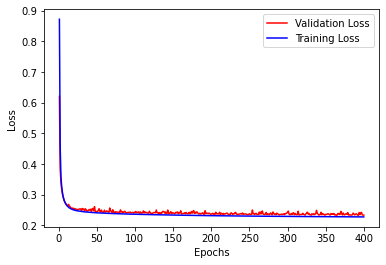

In [ ]:
import matplotlib.pyplot as plt
val_loss = history_detection.history["val_loss"]
loss = history_detection.history["loss"]

epochs = range(1, 401)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Label prediction for the test set

In [ ]:
# Testing the trained network over the testset.
predictions_label = model_detection.predict(X_tst_detection)

# Using argmax function to select the label with the highest probability.
y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])

### Metrics

In [ ]:
### Detection Module

n_cc=1
n_cs=1
n_cr=1
n_sc=1
n_ss=1
n_sr=1
n_rc=1
n_rs=1
n_rr=1

precip_c= 3
precip_r= 2
precip_s= 1

for i in range(len(X_tst_detection)):
    label_predict = y_pred[i]
    label_actual = t_test[i]
    if label_predict==precip_c and label_actual==precip_c:
        n_cc+=1
    if label_predict==precip_s and label_actual==precip_s:
        n_ss+=1
    if label_predict==precip_r and label_actual==precip_r:
        n_rr+=1 
    if label_predict==precip_c and label_actual==precip_s:
        n_cs+=1
    if label_predict==precip_c and label_actual==precip_r:
        n_cr+=1
    if label_predict==precip_s and label_actual==precip_c:
        n_sc+=1
    if label_predict==precip_s and label_actual==precip_r:
        n_sr+=1  
    if label_predict==precip_r and label_actual==precip_c:
        n_rc+=1
    if label_predict==precip_r and label_actual==precip_s:
        n_rs+=1        
        
#Snow
TP_s = n_ss
TN_s = n_cc+n_cr+n_rc+n_rr
FP_s = n_sc+n_sr
FN_s = n_cs+n_rs

precision_s = TP_s/(TP_s+FP_s)
acc_s = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
recall_s = TP_s/(TP_s+FN_s)
f1_score_s = (2*precision_s*recall_s)/(precision_s+recall_s)
FPR_s = FP_s/(FP_s+TN_s)

#Rain
TP_r = n_rr
TN_r = n_cc+n_cs+n_sc+n_ss
FP_r = n_rc+n_rs
FN_r = n_cr+n_sr

precision_r = TP_r/(TP_r+FP_r)
acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
recall_r = TP_r/(TP_r+FN_r)
f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
FPR_r = FP_r/(FP_r+TN_r) 

print('\n For Rainfall Detection Over Ocean:\n')
print('Precision: ',precision_r)
print('Accuracy: ',acc_r)
print('Recall (TPR): ',recall_r)
print('False Alarm (FPR): ',FPR_r)
print('\nF1 Score: ',f1_score_r)

print('----------------------------')
print('\n For Snwofall Detection Over Ocean:\n')
print('Precision: ',precision_s)
print('Accuracy: ',acc_s)
print('Recall (TPR): ',recall_s)
print('False Alarm (FPR): ',FPR_s)
print('\nF1 Score: ',f1_score_s)

#Model
TP = n_cc+n_ss+n_rr
FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)

print('----------------------------')
print('\n For Model Detection Over Ocean:\n')
print('Precision: ',precision)
print('Recall (TPR): ',recall)
print('\nF1 Score: ',f1_score)


 For Rainfall Detection Over Ocean:

Precision:  0.9322507012815576
Accuracy:  0.9473291554759773
Recall (TPR):  0.9646287153365679
False Alarm (FPR):  0.06992719170013767

F1 Score:  0.9481633766179278
----------------------------

 For Snwofall Detection Over Ocean:

Precision:  0.9634492391384254
Accuracy:  0.9473291554759773
Recall (TPR):  0.930069830816396
False Alarm (FPR):  0.03536977491961415

F1 Score:  0.9464653248694673
----------------------------

 For Model Detection Over Ocean:

Precision:  0.9473149450768072
Recall (TPR):  0.9473149450768072

F1 Score:  0.9473149450768072


## **2.2 - Estimation networks (e-DNN)**

In [ ]:
from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))        

### **2.2.1 Snowfall retrieval** 

In [ ]:
# Parameters
hidden_units = 75
dropout = 0

# OCEAN
model_retrieval_snow = Sequential()

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(1))
model_retrieval_snow.add(Activation('relu'))

In [ ]:
model_retrieval_snow.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Snow):\n')
batch_size2 = 600
history_retrieval_snow = model_retrieval_snow.fit(Xf_snow_trn_retrieval, yf_snow_trn_retrieval, epochs=500,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Snow):

Epoch 1/500
933/933 [==============================] - 2s 3ms/step - loss: 0.4220 - mean_absolute_error: 0.1931 - val_loss: 0.3934 - val_mean_absolute_error: 0.1841
Epoch 2/500
933/933 [==============================] - 2s 2ms/step - loss: 0.3633 - mean_absolute_error: 0.1594 - val_loss: 0.3480 - val_mean_absolute_error: 0.1442
Epoch 3/500
933/933 [==============================] - 2s 2ms/step - loss: 0.3371 - mean_absolute_error: 0.1376 - val_loss: 0.3359 - val_mean_absolute_error: 0.1362
Epoch 4/500
933/933 [==============================] - 2s 2ms/step - loss: 0.3289 - mean_absolute_error: 0.1331 - val_loss: 0.3310 - val_mean_absolute_error: 0.1326
Epoch 5/500
933/933 [==============================] - 2s 2ms/step - loss: 0.3255 - mean_absolute_error: 0.1308 - val_loss: 0.3279 - val_mean_absolute_error: 0.1317
Epoch 6/500
933/933 [==============================] - 2s 2ms/step - loss: 0.3227 - mean_absolute_error: 0.1295 - val_loss: 0.3256 - v

933/933 [==============================] - 2s 3ms/step - loss: 0.2938 - mean_absolute_error: 0.1138 - val_loss: 0.3003 - val_mean_absolute_error: 0.1151
Epoch 100/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2938 - mean_absolute_error: 0.1137 - val_loss: 0.3002 - val_mean_absolute_error: 0.1165
Epoch 101/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2936 - mean_absolute_error: 0.1137 - val_loss: 0.3003 - val_mean_absolute_error: 0.1150
Epoch 102/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2931 - mean_absolute_error: 0.1136 - val_loss: 0.3002 - val_mean_absolute_error: 0.1169
Epoch 103/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2931 - mean_absolute_error: 0.1135 - val_loss: 0.3002 - val_mean_absolute_error: 0.1149
Epoch 104/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2932 - mean_absolute_error: 0.1135 - val_loss: 0.3002 - val_mean_absolute_error: 0.1138
Epoch 105/50

Epoch 197/500
933/933 [==============================] - 2s 3ms/step - loss: 0.2881 - mean_absolute_error: 0.1109 - val_loss: 0.2975 - val_mean_absolute_error: 0.1125
Epoch 198/500
933/933 [==============================] - 2s 3ms/step - loss: 0.2882 - mean_absolute_error: 0.1109 - val_loss: 0.2976 - val_mean_absolute_error: 0.1137
Epoch 199/500
933/933 [==============================] - 3s 3ms/step - loss: 0.2878 - mean_absolute_error: 0.1109 - val_loss: 0.2976 - val_mean_absolute_error: 0.1121
Epoch 200/500
933/933 [==============================] - 3s 3ms/step - loss: 0.2880 - mean_absolute_error: 0.1108 - val_loss: 0.2974 - val_mean_absolute_error: 0.1123
Epoch 201/500
933/933 [==============================] - 3s 3ms/step - loss: 0.2879 - mean_absolute_error: 0.1109 - val_loss: 0.2974 - val_mean_absolute_error: 0.1134
Epoch 202/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2878 - mean_absolute_error: 0.1108 - val_loss: 0.2973 - val_mean_absolute_error: 0.113

933/933 [==============================] - 2s 2ms/step - loss: 0.2862 - mean_absolute_error: 0.1101 - val_loss: 0.2970 - val_mean_absolute_error: 0.1107
Epoch 247/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2862 - mean_absolute_error: 0.1100 - val_loss: 0.2970 - val_mean_absolute_error: 0.1119
Epoch 248/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2861 - mean_absolute_error: 0.1100 - val_loss: 0.2970 - val_mean_absolute_error: 0.1125
Epoch 249/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2858 - mean_absolute_error: 0.1099 - val_loss: 0.2969 - val_mean_absolute_error: 0.1121
Epoch 250/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2858 - mean_absolute_error: 0.1100 - val_loss: 0.2971 - val_mean_absolute_error: 0.1120
Epoch 251/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2860 - mean_absolute_error: 0.1099 - val_loss: 0.2970 - val_mean_absolute_error: 0.1135
Epoch 252/50

933/933 [==============================] - 2s 2ms/step - loss: 0.2835 - mean_absolute_error: 0.1089 - val_loss: 0.2964 - val_mean_absolute_error: 0.1121
Epoch 345/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2834 - mean_absolute_error: 0.1088 - val_loss: 0.2962 - val_mean_absolute_error: 0.1109
Epoch 346/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2832 - mean_absolute_error: 0.1088 - val_loss: 0.2963 - val_mean_absolute_error: 0.1118
Epoch 347/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2830 - mean_absolute_error: 0.1088 - val_loss: 0.2964 - val_mean_absolute_error: 0.1139
Epoch 348/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2834 - mean_absolute_error: 0.1088 - val_loss: 0.2960 - val_mean_absolute_error: 0.1118
Epoch 349/500
933/933 [==============================] - 2s 2ms/step - loss: 0.2835 - mean_absolute_error: 0.1088 - val_loss: 0.2961 - val_mean_absolute_error: 0.1119
Epoch 350/50

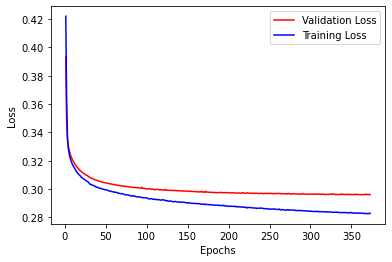

In [ ]:
import matplotlib.pyplot as plt
val_loss = history_retrieval_snow.history["val_loss"]
loss = history_retrieval_snow.history["loss"]

epochs = range(1, 374)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_snow = model_retrieval_snow.predict(Xf_snow_tst_retrieval)

In [ ]:
model_retrieval_snow.evaluate(Xf_snow_tst_retrieval, yf_snow_tst_retrieval, batch_size = batch_size2)

500/500 [==============================] - 0s 561us/step - loss: 0.2975 - mean_absolute_error: 0.1120


[0.29746168851852417, 0.11197046935558319]

### **2.2.2 Rainfall retrieval** 

In [ ]:
# Parameters
hidden_units = 75
dropout = 0

# OCEAN
model_retrieval_rain = Sequential()

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))


model_retrieval_rain.add(Dense(1))
model_retrieval_rain.add(Activation('relu'))

In [ ]:
model_retrieval_rain.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = mean_absolute_error,
              metrics= root_mean_squared_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ReduceLROnPlateau
    (factor=0.1, patience=5, min_lr=0.00001, verbose=2),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Rain):\n')
batch_size2 = 600
history_retrieval_rain = model_retrieval_rain.fit(Xf_rain_trn_retrieval, yf_rain_trn_retrieval, epochs=500,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Rain):

Epoch 1/500
234/234 [==============================] - 1s 2ms/step - loss: 1.9727 - root_mean_squared_error: 4.4440 - val_loss: 1.7869 - val_root_mean_squared_error: 4.3019
Epoch 2/500
234/234 [==============================] - 0s 2ms/step - loss: 1.6521 - root_mean_squared_error: 4.0484 - val_loss: 1.5107 - val_root_mean_squared_error: 3.9111
Epoch 3/500
234/234 [==============================] - 0s 2ms/step - loss: 1.4400 - root_mean_squared_error: 3.7012 - val_loss: 1.3670 - val_root_mean_squared_error: 3.6122
Epoch 4/500
234/234 [==============================] - 0s 2ms/step - loss: 1.3449 - root_mean_squared_error: 3.4633 - val_loss: 1.3133 - val_root_mean_squared_error: 3.4711
Epoch 5/500
234/234 [==============================] - 0s 2ms/step - loss: 1.3029 - root_mean_squared_error: 3.3737 - val_loss: 1.2829 - val_root_mean_squared_error: 3.4117
Epoch 6/500
234/234 [==============================] - 1s 2ms/step - loss: 1.2744 - root_mean_

Epoch 48/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1575 - root_mean_squared_error: 3.1919 - val_loss: 1.1625 - val_root_mean_squared_error: 3.2829
Epoch 49/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1572 - root_mean_squared_error: 3.1863 - val_loss: 1.1624 - val_root_mean_squared_error: 3.2782
Epoch 50/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1569 - root_mean_squared_error: 3.1876 - val_loss: 1.1623 - val_root_mean_squared_error: 3.2777
Epoch 51/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1566 - root_mean_squared_error: 3.1761 - val_loss: 1.1619 - val_root_mean_squared_error: 3.2885
Epoch 52/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1564 - root_mean_squared_error: 3.1867 - val_loss: 1.1618 - val_root_mean_squared_error: 3.2835
Epoch 53/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1561 - root_mean_squared_error: 3.1935 - val_loss: 1

Epoch 142/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1419 - root_mean_squared_error: 3.1574 - val_loss: 1.1539 - val_root_mean_squared_error: 3.2739
Epoch 143/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1417 - root_mean_squared_error: 3.1603 - val_loss: 1.1538 - val_root_mean_squared_error: 3.2760
Epoch 144/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1417 - root_mean_squared_error: 3.1727 - val_loss: 1.1539 - val_root_mean_squared_error: 3.2756
Epoch 145/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1415 - root_mean_squared_error: 3.1639 - val_loss: 1.1539 - val_root_mean_squared_error: 3.2696
Epoch 146/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1414 - root_mean_squared_error: 3.1661 - val_loss: 1.1543 - val_root_mean_squared_error: 3.2596
Epoch 147/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1413 - root_mean_squared_error: 3.1676 - val_l

Epoch 189/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1364 - root_mean_squared_error: 3.1649 - val_loss: 1.1517 - val_root_mean_squared_error: 3.2656
Epoch 190/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1363 - root_mean_squared_error: 3.1507 - val_loss: 1.1516 - val_root_mean_squared_error: 3.2748
Epoch 191/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1362 - root_mean_squared_error: 3.1566 - val_loss: 1.1515 - val_root_mean_squared_error: 3.2748
Epoch 192/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1361 - root_mean_squared_error: 3.1428 - val_loss: 1.1515 - val_root_mean_squared_error: 3.2709
Epoch 193/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1360 - root_mean_squared_error: 3.1663 - val_loss: 1.1515 - val_root_mean_squared_error: 3.2636
Epoch 194/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1358 - root_mean_squared_error: 3.1457 - val_l

Epoch 236/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1312 - root_mean_squared_error: 3.1512 - val_loss: 1.1493 - val_root_mean_squared_error: 3.2630
Epoch 237/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1311 - root_mean_squared_error: 3.1441 - val_loss: 1.1493 - val_root_mean_squared_error: 3.2680
Epoch 238/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1311 - root_mean_squared_error: 3.1403 - val_loss: 1.1495 - val_root_mean_squared_error: 3.2574
Epoch 239/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1309 - root_mean_squared_error: 3.1407 - val_loss: 1.1492 - val_root_mean_squared_error: 3.2704
Epoch 240/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1308 - root_mean_squared_error: 3.1435 - val_loss: 1.1493 - val_root_mean_squared_error: 3.2597
Epoch 241/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1307 - root_mean_squared_error: 3.1406 - val_l

Epoch 283/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1263 - root_mean_squared_error: 3.1334 - val_loss: 1.1472 - val_root_mean_squared_error: 3.2653
Epoch 284/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1262 - root_mean_squared_error: 3.1325 - val_loss: 1.1474 - val_root_mean_squared_error: 3.2544
Epoch 285/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1261 - root_mean_squared_error: 3.1310 - val_loss: 1.1474 - val_root_mean_squared_error: 3.2567
Epoch 286/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1260 - root_mean_squared_error: 3.1263 - val_loss: 1.1472 - val_root_mean_squared_error: 3.2662
Epoch 287/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1259 - root_mean_squared_error: 3.1525 - val_loss: 1.1471 - val_root_mean_squared_error: 3.2677
Epoch 288/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1257 - root_mean_squared_error: 3.1373 - val_l

Epoch 330/500
234/234 [==============================] - 1s 2ms/step - loss: 1.1217 - root_mean_squared_error: 3.1132 - val_loss: 1.1455 - val_root_mean_squared_error: 3.2544
Epoch 331/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1215 - root_mean_squared_error: 3.1146 - val_loss: 1.1453 - val_root_mean_squared_error: 3.2645
Epoch 332/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1215 - root_mean_squared_error: 3.1229 - val_loss: 1.1452 - val_root_mean_squared_error: 3.2629
Epoch 333/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1213 - root_mean_squared_error: 3.1227 - val_loss: 1.1456 - val_root_mean_squared_error: 3.2725
Epoch 334/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1213 - root_mean_squared_error: 3.1163 - val_loss: 1.1453 - val_root_mean_squared_error: 3.2527
Epoch 335/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1212 - root_mean_squared_error: 3.1515 - val_l

Epoch 377/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1172 - root_mean_squared_error: 3.1224 - val_loss: 1.1439 - val_root_mean_squared_error: 3.2518
Epoch 378/500
234/234 [==============================] - 1s 2ms/step - loss: 1.1172 - root_mean_squared_error: 3.1071 - val_loss: 1.1438 - val_root_mean_squared_error: 3.2609
Epoch 379/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1171 - root_mean_squared_error: 3.1107 - val_loss: 1.1438 - val_root_mean_squared_error: 3.2646
Epoch 380/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1169 - root_mean_squared_error: 3.1092 - val_loss: 1.1438 - val_root_mean_squared_error: 3.2549
Epoch 381/500
234/234 [==============================] - 1s 2ms/step - loss: 1.1169 - root_mean_squared_error: 3.1151 - val_loss: 1.1439 - val_root_mean_squared_error: 3.2527
Epoch 382/500
234/234 [==============================] - 1s 2ms/step - loss: 1.1168 - root_mean_squared_error: 3.1139 - val_l

Epoch 424/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1130 - root_mean_squared_error: 3.1063 - val_loss: 1.1424 - val_root_mean_squared_error: 3.2562
Epoch 425/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1129 - root_mean_squared_error: 3.0931 - val_loss: 1.1424 - val_root_mean_squared_error: 3.2542
Epoch 426/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1128 - root_mean_squared_error: 3.1011 - val_loss: 1.1424 - val_root_mean_squared_error: 3.2501
Epoch 427/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1128 - root_mean_squared_error: 3.0997 - val_loss: 1.1424 - val_root_mean_squared_error: 3.2498
Epoch 428/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1126 - root_mean_squared_error: 3.0956 - val_loss: 1.1426 - val_root_mean_squared_error: 3.2469
Epoch 429/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1126 - root_mean_squared_error: 3.1016 - val_l

Epoch 471/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1089 - root_mean_squared_error: 3.0858 - val_loss: 1.1415 - val_root_mean_squared_error: 3.2544
Epoch 472/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1089 - root_mean_squared_error: 3.0902 - val_loss: 1.1418 - val_root_mean_squared_error: 3.2466
Epoch 473/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1088 - root_mean_squared_error: 3.0929 - val_loss: 1.1415 - val_root_mean_squared_error: 3.2546
Epoch 474/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1087 - root_mean_squared_error: 3.0950 - val_loss: 1.1416 - val_root_mean_squared_error: 3.2605
Epoch 475/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1086 - root_mean_squared_error: 3.0804 - val_loss: 1.1414 - val_root_mean_squared_error: 3.2487
Epoch 476/500
234/234 [==============================] - 0s 2ms/step - loss: 1.1085 - root_mean_squared_error: 3.0830 - val_l

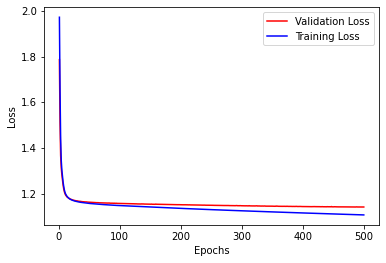

In [ ]:
val_loss = history_retrieval_rain.history["val_loss"]
loss = history_retrieval_rain.history["loss"]

epochs = range(1, 501)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_rain = model_retrieval_rain.predict(Xf_rain_tst_retrieval)

In [ ]:
model_retrieval_rain.evaluate(Xf_rain_tst_retrieval, yf_rain_tst_retrieval, batch_size = batch_size2)

126/126 [==============================] - 0s 570us/step - loss: 1.1264 - root_mean_squared_error: 3.0792


[1.1263954639434814, 3.0791640281677246]

# Save Files

In [ ]:
import scipy
from scipy.io import savemat

model_detection.save('Models\DPR\Ocean\model_dtc',save_format='h5')
model_retrieval_snow.save('Models\DPR\Ocean\model_snow',save_format='h5')
model_retrieval_rain.save('Models\DPR\Ocean\model_rain',save_format='h5')

fp_DPR_ocean = 'Models/DPR/Ocean/files_DPR_ocean.mat'
scipy.io.savemat(fp_DPR_ocean, {'mean_detection_DPR_ocean': mean_detection,'std_detection_DPR_ocean':std_detection,
                               'mean_snow_retrieval_DPR_ocean': mean_snow_retrieval,'std_snow_retrieval_DPR_ocean':std_snow_retrieval,
                               'mean_rain_retrieval_DPR_ocean': mean_rain_retrieval,'std_rain_retrieval_DPR_ocean':std_rain_retrieval})
